In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import mne
import os
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [3]:
!pip install antropy



  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.3 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16879 sha256=63043dd994ffd9e51c2eabdb42b75e6595b45f4e1f270f675c25c213f586385a
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy


In [4]:
import antropy as ant

# # Permutation entropy
# print(ant.perm_entropy(x, normalize=False))
# # Spectral entropy
# print(ant.spectral_entropy(x, sf=100, method='welch', normalize=False))
# # Singular value decomposition entropy
# print(ant.svd_entropy(x, normalize=False))
# # Approximate entropy
# print(ant.app_entropy(x))
# # Sample entropy
# print(ant.sample_entropy(x))

In [5]:
p1Path = "/kaggle/input/stressnet-eeg-data/SEED_EEG/Preprocessed_EEG/1_20131027.mat"

In [6]:
data = loadmat(p1Path)
print(type(data))
data_1_trail= data['djc_eeg1']

<class 'dict'>


In [7]:
len(data_1_trail)

62

In [8]:
data_1_trail_channel = data_1_trail[0,:]
print(len(data_1_trail_channel))

47001


In [9]:
def extract(data_1_trail_channel):
    fs = 1000
    filter_order = 4

    alpha_band = (8, 13)
    beta_band = (13, 30)
    theta_band = (4, 7)

    # Design Butterworth filters for each frequency band
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    b_alpha, a_alpha = butter_bandpass(alpha_band[0], alpha_band[1], fs, order=filter_order)
    b_beta, a_beta = butter_bandpass(beta_band[0], beta_band[1], fs, order=filter_order)
    b_theta, a_theta = butter_bandpass(theta_band[0], theta_band[1], fs, order=filter_order)

    # Apply the Butterworth filters to the EEG data
    alpha_signal = filtfilt(b_alpha, a_alpha, data_1_trail_channel)
    beta_signal = filtfilt(b_beta, a_beta, data_1_trail_channel)
    theta_signal = filtfilt(b_theta, a_theta, data_1_trail_channel)

#     t = np.arange(len(data_1_trail_channel)) / fs

#     plt.figure(figsize=(12, 6))

#     plt.subplot(321)
#     plt.plot(t, data_1_trail_channel)
#     plt.title('Original EEG Signal')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')

#     plt.subplot(322)
#     plt.plot(t, alpha_signal)
#     plt.title('Alpha Band Filtered Signal')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')

#     plt.subplot(323)
#     plt.plot(t, beta_signal)
#     plt.title('Beta Band Filtered Signal')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')

#     plt.subplot(324)
#     plt.plot(t, theta_signal)
#     plt.title('Theta Band Filtered Signal')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')

#     plt.tight_layout()
#     plt.show()
    return alpha_signal, beta_signal,theta_signal

def getenergy(s):
    return ant.app_entropy(s),ant.perm_entropy(s, normalize=True)



In [10]:
def getavgenergy(data_1_trail_channel):
    a,b,t= extract(data_1_trail_channel)
    avga1,avga2 = getenergy(a)
    avgb1 ,avgb2 = getenergy(b)
    avgt1 ,avgt2 = getenergy(b)
    avg1 = (avga1+avgb1+avgt1)/3
    avg2 = (avga2+avgb2+avgt2)/3
    return avg1,avg2
    

In [11]:
from PIL import Image

def getimg(avgs,name):
    print(name)
    na = []
    s1 = [4,1,2,3,5]
    s2 = range(6,51)
    s3 = range(51,58)
    s4 = range(58,63)
    na.append(0)
    na.append(0)
    for i in s1:
        na.append(avgs[i-1])
    na.append(0)
    na.append(0)
    for i in s2:
        na.append(avgs[i-1])

    na.append(0)   
    for i in s3:
        na.append(avgs[i-1])
    na.append(0) 
    na.append(0) 
    na.append(0) 
    for i in s4:
        na.append(avgs[i-1])

    na.append(0) 
    na.append(0) 
    nb = np.array(na)
    image = nb.reshape((8, 9))

#     normalized_image = (image - image.min()) / (image.max() - image.min())
    normalized_image = image

    img = Image.fromarray((normalized_image * 255).astype('uint8'))
    img.save(name)

    # Plot the normalized 2D image
    plt.imshow(normalized_image, cmap='plasma')  # You can choose a different colormap
    plt.colorbar()
    plt.show()
    # na.append(avgs[])


In [12]:
# index = 1 
# for j in tqdm(data):
#     if(j>'c'):
#         avgs = []
#         for i in data[str(j)] :
#         #     print(index," :  ",getavgenergy(i)[0])
#             en = getavgenergy(i)
#             avgs.append(en[0])
#         getimg(avgs,str(index)+'.png')
#         index+=1


# Projections

#### extra


In [13]:
# data = np.column_stack((theta_signal, alpha_signal, beta_signal))

# # Perform azimuthal projection
# r = np.linalg.norm(data, axis=1)  # Calculate radial distance from origin
# theta = np.arctan2(data[:, 1], data[:, 0])  # Calculate azimuthal angle

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Create the azimuthal projection plot
# ax.scatter(theta, r, c='b', marker='o')

# # Set labels
# ax.set_xlabel('Theta')
# ax.set_ylabel('Radius')
# ax.set_zlabel('Alpha')

# plt.show()

In [14]:
# n = 100

# alpha_downsampled = alpha_signal[::n]
# beta_downsampled = beta_signal[::n]
# theta_downsampled = theta_signal[::n]

In [15]:
# import matplotlib.cm as cm

# m = 471

# # Define the dimensions of your 3D grid (e.g., brain volume)
# x = np.linspace(-1, 1, num=m)  # Adjust as needed
# y = np.linspace(-1, 1, num=m)  # Adjust as needed
# z = np.linspace(-1, 1, num=m)  # Adjust as needed

# # Create a 3D grid
# X, Y, Z = np.meshgrid(x, y, z)

# # Define the combined 3D signal based on your waves
# combined_signal = alpha_downsampled * X + beta_downsampled * Y + theta_downsampled * Z  # Adjust as needed

# # Define the azimuthal projection plane
# # For simplicity, let's assume it's the XY plane (z = 0)
# projection_plane = Z == 0

# # Perform the azimuthal projection onto the XY plane
# projected_image = combined_signal[projection_plane]

# projected_image = projected_image.reshape(m, m)


# # Visualize the projected 2D image
# plt.imshow(projected_image, cmap='autumn')  # Adjust colormap as needed
# plt.show()


# New method


In [16]:
# data1= pd.read_excel('/kaggle/input/electrode-position/channel-order.xlsx')
# data1


In [17]:
# # Convert azimuthal and polar angles to radians
# azimuthal_angles = np.radians(data1['Azimuthal'])
# polar_angles = np.radians(data1['Polar'])

# # Calculate Cartesian coordinates using azimuthal projection
# x = polar_angles * np.cos(azimuthal_angles)
# y = polar_angles * np.sin(azimuthal_angles)



In [18]:
# new_column = pd.Series(y, name='y')

# # Add the new column to the DataFrame
# data1['y'] = new_column
# data1,x
# data1.to_excel('/kaggle/working/channel-order1.xlsx', index=False)

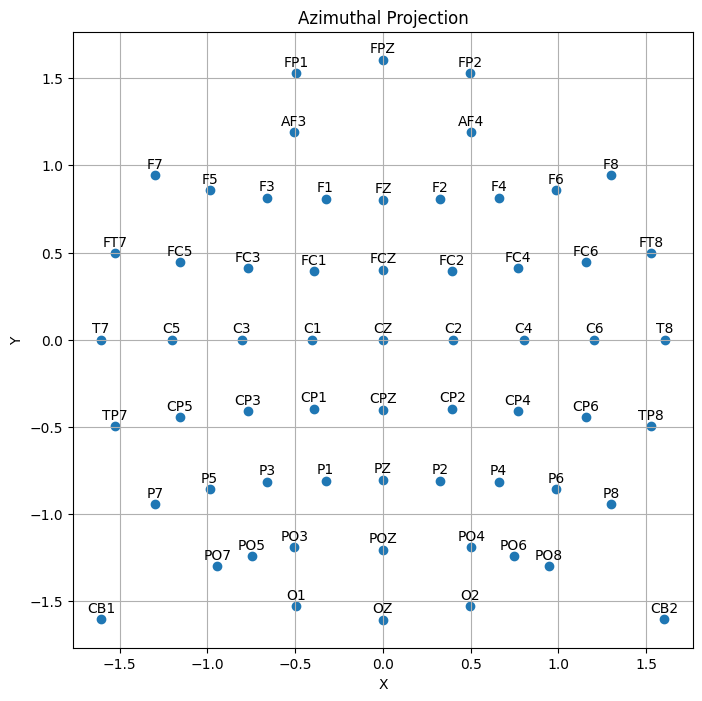

In [19]:
df = pd.read_excel('/kaggle/input/electrode-xy/channel-order1.xlsx')
# Create a scatter plot
x = df['x']
y = df['y']
plt.figure(figsize=(8, 8))
plt.scatter(x, y)

# Annotate the points with labels
for i in range(len(df)):
    plt.annotate(df['Electrode'][i], (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha="center")

# Set labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Azimuthal Projection")

# Show the plot
plt.grid()
plt.show()


In [20]:
import random
def getavgenergy2(data_1_trail_channel):
    a,b,t= extract(data_1_trail_channel)
    avga1,avga2 = getenergy(a)
    avgb1 ,avgb2 = getenergy(b)
    avgt1 ,avgt2 = getenergy(b)
    return avga1,avgb1,avgt1
#     rfr1= random.uniform(0, 0.5)
#     rfr2= random.uniform(0, 0.5)
#     rfr3= random.uniform(0, 0.5)
#     return 0.5+rfr1,0.2+rfr2,0.1+rfr3

In [21]:
def work(data,name2):
    
    emotions = [1,0,-1,-1,0,1,-1,0,1,1,0,-1,0,1,-1]
    index = 1 
    for j in data:
        avgs = []
        if(j>'c'):
            for i in tqdm(data[str(j)]) :
    #             print(index," :  ",getavgenergy(i)[0])
                a,b,t = getavgenergy2(i)
    #             print(a,b,t)
                avgs.append((a,b,t))

#             print(avgs)

            data2  = avgs

            # Extract the values from the selected column
            column_values1 = [x[0] for x in data2]
            column_values2 = [x[1] for x in data2]
            column_values3 = [x[2] for x in data2]

            # Find the minimum and maximum values in the column
            min_value1 = min(column_values1)
            max_value1 = max(column_values1)
            value_range1 = max_value1 - min_value1

            min_value2 = min(column_values2)
            max_value2 = max(column_values2)
            value_range2 = max_value2 - min_value2

            min_value3 = min(column_values3)
            max_value3 = max(column_values3)
            value_range3 = max_value3 - min_value3
#             print(min_value1)
            # Normalize the values in the column and scale to [0, 255]
            normalized_data = [(int((x[0] - min_value1) / value_range1 * 255), int((x[1] - min_value2) / value_range2 * 255), int((x[2] - min_value3) / value_range3 * 255)) for x in data2]

            # Print the normalized data
            # print(normalized_data)


            normdata = np.array(normalized_data)

            df['rgb'] = normalized_data

            df
            selected_columns = ['x', 'y', 'rgb']

            # Use the values attribute to convert the selected columns into a NumPy array
            coord = df[selected_columns].values

            # print(coord)



            data3  = coord
            mult = 30
            pad = 10

            column_values1 = [x[0] for x in data3]
            column_values2 = [x[1] for x in data3]

            min_value1 = min(column_values1)
            max_value1 = max(column_values1)
            value_range1 = max_value1 - min_value1

            min_value2 = min(column_values2)
            max_value2 = max(column_values2)
            value_range2 = max_value2 - min_value2


            # Normalize the values in the column and scale to [0, 255]
            normalized_data2 = [[(int((x[0] - min_value1) / value_range1 * mult))+pad, (int((x[1] - min_value2) / value_range2 * mult))+pad, x[2]] for x in data3]

            # Print the normalized data
            # print(normalized_data2)
#             print(len(normalized_data2))
            from PIL import Image, ImageDraw

            # Define the image size and create a blank image
            width = mult + pad +pad # Adjust this to your desired image width
            height =mult + pad +pad # Adjust this to your desired image height
            image = Image.new('RGB', (width, height), (0, 0, 0))  # Initialize with a black background

            # Define your (x, y) coordinates and corresponding RGB values
            coordinates = normalized_data2

            # Create a drawing context on the image
            draw = ImageDraw.Draw(image)

            # Draw colored pixels at the specified (x, y) coordinates
            for (x, y, color) in coordinates:
                draw.point((x, y), fill=color)

            # Save the image to a file
#             image.save('output_image.png')
            # print(image)




            image_data = np.array(image)
            from IPython.display import display
            # display(image)




            image_data = np.array(image)
            count = 0 
            for x in range(width):
                for y in range(height):
                    if all(image_data[y, x] != [0, 0, 0]): 
                        count += 1
#             print(count)

            # for ll in tqdm(range(1,6)):
            for i in (range(0,2)):
                for x in range(width):
                    for y in range(height):
                        if all(image_data[y, x] == [0, 0, 0]):  # Check if this pixel is black (unfilled)
                            # Find the nearest filled pixels
                            nearest_points = []
                            for dx in [-1, 0, 1]:
                                for dy in [-1, 0, 1]:
                                    if 0 <= x + dx < width and 0 <= y + dy < height:
                                        if all(image_data[y + dy, x + dx] != [0, 0, 0]):
                                            nearest_points.append((x + dx, y + dy))

                            if nearest_points:
                                # Calculate the average color of the nearest filled pixels
                                average_color = np.mean([image_data[y, x] for x, y in nearest_points], axis=0).astype(int)
                                draw.point((x, y), fill=tuple(average_color))
                image_data = np.array(image)
                count = 0 
                for x in range(width):
                    for y in range(height):
                        if all(image_data[y, x] != [0, 0, 0]): 
                            count += 1
            #         print(count)

            # Save or display the interpolated image
            # image.save('interpolated_image.png')
            display(image)
            name = 'IPI_'+ name2+'_'+str(index)+'_'+str(emotions[index-1])+'.png'
            image.save(name)
            normdata = np.array(normalized_data)
            print(index)
            index+=1
           




    

In [22]:
print("hi")

hi


In [23]:
import os

# Specify the directory path
directory_path = '/kaggle/input/stressnet-eeg-data/SEED_EEG/Preprocessed_EEG'  # Change this to the directory you want to iterate through

# Use os.listdir() to get a list of all files and directories in the specified directory
files_and_directories = os.listdir(directory_path)

names = []

for item in files_and_directories:
    if(item < 'a'):
        names.append(item)
#         item_path = os.path.join(directory_path, item)  # Create the full path to the item
#         if os.path.isfile(item_path):  # Check if it's a file (not a directory)
#             names.append(item_path)  # This is a file
names.sort()

paths = []
for name in names:
    item_path = os.path.join(directory_path, name)  # Create the full path to the item
    if os.path.isfile(item_path):  # Check if it's a file (not a directory)
        paths.append(item_path)
        
len(paths)
    

45

In [24]:
# for i in range(len(paths)-39):
#     data = loadmat(paths[i])

#     k,j = names[i].split('.')
#     work(data,k)




6_20131016


100%|██████████| 62/62 [07:08<00:00,  6.91s/it]


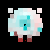

1


100%|██████████| 62/62 [07:00<00:00,  6.78s/it]


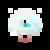

2


100%|██████████| 62/62 [05:40<00:00,  5.49s/it]


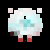

3


100%|██████████| 62/62 [07:06<00:00,  6.87s/it]


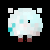

4


100%|██████████| 62/62 [05:26<00:00,  5.26s/it]


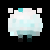

5


100%|██████████| 62/62 [05:59<00:00,  5.79s/it]


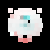

6


100%|██████████| 62/62 [07:06<00:00,  6.89s/it]


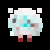

7


100%|██████████| 62/62 [06:16<00:00,  6.07s/it]


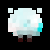

8


100%|██████████| 62/62 [08:43<00:00,  8.44s/it]


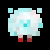

9


100%|██████████| 62/62 [08:59<00:00,  8.70s/it]


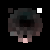

10


100%|██████████| 62/62 [07:38<00:00,  7.40s/it]


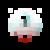

11


100%|██████████| 62/62 [07:14<00:00,  7.01s/it]


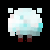

12


100%|██████████| 62/62 [07:16<00:00,  7.04s/it]


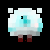

13


100%|██████████| 62/62 [07:23<00:00,  7.15s/it]


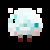

14


100%|██████████| 62/62 [05:34<00:00,  5.40s/it]


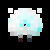

15


In [25]:
numd = 34

for i in range(numd,numd+1):
    data = loadmat(paths[i])

    k,j = names[i].split('.')
    print(k)
    work(data,k)

In [26]:
# for i in range(3,4):
#     data = loadmat(paths[i])
#     k,j = names[i].split('.')
#     print(k)
#     work(data,k)

In [27]:


# df['rgb'] = normalized_data
# selected_columns = ['x', 'y', 'rgb']

# # Use the values attribute to convert the selected columns into a NumPy array
# coord = df[selected_columns].values

# # print(coord)



# data3  = coord
# mult = 30
# pad = 10

# column_values1 = [x[0] for x in data3]
# column_values2 = [x[1] for x in data3]

# min_value1 = min(column_values1)
# max_value1 = max(column_values1)
# value_range1 = max_value1 - min_value1

# min_value2 = min(column_values2)
# max_value2 = max(column_values2)
# value_range2 = max_value2 - min_value2


# # Normalize the values in the column and scale to [0, 255]
# normalized_data2 = [[(int((x[0] - min_value1) / value_range1 * mult))+pad, (int((x[1] - min_value2) / value_range2 * mult))+pad, x[2]] for x in data3]

# # Print the normalized data
# # print(normalized_data2)
# # print(len(normalized_data2))
# from PIL import Image, ImageDraw

# # Define the image size and create a blank image
# width = mult + pad +pad # Adjust this to your desired image width
# height =mult + pad +pad # Adjust this to your desired image height
# image = Image.new('RGB', (width, height), (0, 0, 0))  # Initialize with a black background

# # Define your (x, y) coordinates and corresponding RGB values
# coordinates = normalized_data2

# # Create a drawing context on the image
# draw = ImageDraw.Draw(image)

# # Draw colored pixels at the specified (x, y) coordinates
# for (x, y, color) in coordinates:
#     draw.point((x, y), fill=color)

# # Save the image to a file
# # image.save('output_image.png')
# # print(image)




# image_data = np.array(image)
# from IPython.display import display
# display(image)




# image_data = np.array(image)
# count = 0 
# for x in range(width):
#     for y in range(height):
#         if all(image_data[y, x] != [0, 0, 0]): 
#             count += 1
# print(count)

# # for ll in tqdm(range(1,6)):
# for i in tqdm(range(0,2)):
#     for x in range(width):
#         for y in range(height):
#             if all(image_data[y, x] == [0, 0, 0]):  # Check if this pixel is black (unfilled)
#                 # Find the nearest filled pixels
#                 nearest_points = []
#                 for dx in [-1, 0, 1]:
#                     for dy in [-1, 0, 1]:
#                         if 0 <= x + dx < width and 0 <= y + dy < height:
#                             if all(image_data[y + dy, x + dx] != [0, 0, 0]):
#                                 nearest_points.append((x + dx, y + dy))

#                 if nearest_points:
#                     # Calculate the average color of the nearest filled pixels
#                     average_color = np.mean([image_data[y, x] for x, y in nearest_points], axis=0).astype(int)
#                     draw.point((x, y), fill=tuple(average_color))
#     image_data = np.array(image)
#     count = 0 
#     for x in range(width):
#         for y in range(height):
#             if all(image_data[y, x] != [0, 0, 0]): 
#                 count += 1
# #         print(count)

# # Save or display the interpolated image
# # image.save('interpolated_image.png')
# display(image)
# name = 'interpolated_image_'+ str(i)+'.png'
# image.save(name)

In [28]:
# import shutil
# from zipfile import ZipFile


In [29]:
# # Define the directory to be zipped
# source_dir = '/kaggle/working/'

# # Define the zip file name
# zip_filename = '/kaggle/working/archive.zip'

# # Create a ZipFile object in write mode
# with ZipFile(zip_filename, 'w') as zipf:
#     # Walk through the source directory and add its contents to the zip file
#     for foldername, subfolders, filenames in os.walk(source_dir):
#         for filename in filenames:
#             file_path = os.path.join(foldername, filename)
#             zipf.write(file_path, os.path.relpath(file_path, source_dir))
